In [2]:
# Step 1: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Step 2: Load data
books = pd.read_csv("/content/drive/MyDrive/books.csv")
ratings = pd.read_csv("/content/drive/MyDrive/ratings.csv")

# Step 3: Merge rating with book metadata (excluding num_pages)
df = ratings.merge(books[['book_id', 'average_rating', 'title']], on='book_id')

# Step 4: Create binary label: 1 if rating ≥ 4 else 0
df['label'] = (df['rating'] >= 4).astype(int)

# Step 5: Clean data (drop rows with missing average_rating)
df = df.dropna(subset=['average_rating'])

# Step 6: Select features
X = df[['average_rating', 'rating']]
y = df['label'].values

# Step 7: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)


In [6]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_size=2)


In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 10/50, Loss: 0.6774
Epoch 20/50, Loss: 0.6637
Epoch 30/50, Loss: 0.6486
Epoch 40/50, Loss: 0.6320
Epoch 50/50, Loss: 0.6141


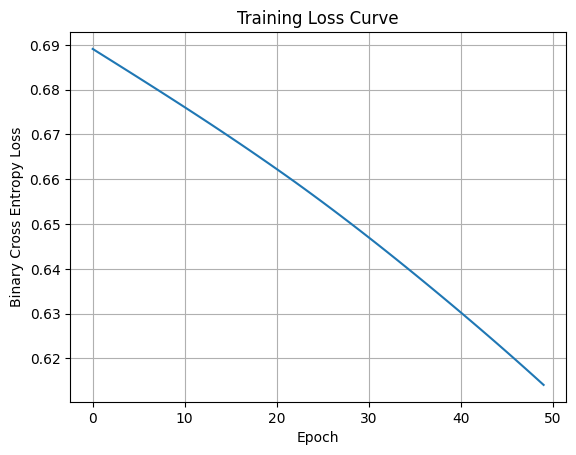

In [8]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


In [9]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_labels = (predictions > 0.5).float()

# Convert tensors to numpy arrays
y_true = y_test_tensor.numpy()
y_pred = predicted_labels.numpy()

# Evaluation Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")


Accuracy:  0.9288
Precision: 0.9033
Recall:    1.0000
F1-score:  0.9492
